In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

### **Read the raw data**

In [124]:
df = pd.read_csv("/kaggle/input/uber-uncleaned-dataset/Uber Uncleaned Dataset.csv")
df.head(7)

,id,timestamp,timezone,source,destination,cab_type,product_id,name,price,distance,...,precipIntensityMax,uvIndexTime,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime
0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,1.544953e+09,America/New_York,Haymarket Square,North Station,Lyft,lyft_line,Shared,5.0,0.44,...,0.1276,1544979600,39.89,1545012000,43.68,1544968800,33.73,1545012000,38.07,1544958000
1,4bd23055-6827-41c6-b23b-3c491f24e74d,1.543284e+09,America/New_York,Haymarket Square,North Station,Lyft,lyft_premier,Lux,11.0,0.44,...,0.1300,1543251600,40.49,1543233600,47.30,1543251600,36.20,1543291200,43.92,1543251600
2,981a3613-77af-4620-a42a-0c0866077d1e,1.543367e+09,America/New_York,Haymarket Square,North Station,Lyft,lyft,Lyft,7.0,0.44,...,0.1064,1543338000,35.36,1543377600,47.55,1543320000,31.04,1543377600,44.12,1543320000
3,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,1.543554e+09,America/New_York,Haymarket Square,North Station,Lyft,lyft_luxsuv,Lux Black XL,26.0,0.44,...,0.0000,1543507200,34.67,1543550400,45.03,1543510800,30.30,1543550400,38.53,1543510800
4,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,1.543463e+09,America/New_York,Haymarket Square,North Station,Lyft,lyft_plus,Lyft XL,9.0,0.44,...,0.0001,1543420800,33.10,1543402800,42.18,1543420800,29.11,1543392000,35.75,1543420800
5,f6f6d7e4-3e18-4922-a5f5-181cdd3fa6f2,1.545071e+09,America/New_York,Haymarket Square,North Station,Lyft,lyft_lux,Lux Black,16.5,0.44,...,0.0221,1545066000,34.19,1545048000,40.66,1545022800,27.39,1545044400,34.97,1545080400
6,462816a3-820d-408b-8549-0b39e82f65ac,1.543209e+09,America/New_York,Back Bay,Northeastern University,Lyft,lyft_plus,Lyft XL,10.5,1.08,...,0.1245,1543251600,40.67,1543233600,46.46,1543255200,37.45,1543291200,43.81,1543251600


In [125]:
df["timezone"].unique()

array(['America/New_York'], dtype=object)

In [126]:
df.columns

Index(['id', 'timestamp', 'timezone', 'source', 'destination', 'cab_type',
       'product_id', 'name', 'price', 'distance', 'surge_multiplier',
       'latitude', 'longitude', 'temperature', 'apparentTemperature',
       'short_summary', 'long_summary', 'precipIntensity', 'precipProbability',
       'humidity', 'windSpeed', 'windGust', 'windGustTime', 'visibility',
       'temperatureHigh', 'temperatureHighTime', 'temperatureLow',
       'temperatureLowTime', 'apparentTemperatureHigh',
       'apparentTemperatureHighTime', 'apparentTemperatureLow',
       'apparentTemperatureLowTime', 'icon', 'dewPoint', 'pressure',
       'windBearing', 'cloudCover', 'uvIndex', 'visibility.1', 'ozone',
       'sunriseTime', 'sunsetTime', 'moonPhase', 'precipIntensityMax',
       'uvIndexTime', 'temperatureMin', 'temperatureMinTime', 'temperatureMax',
       'temperatureMaxTime', 'apparentTemperatureMin',
       'apparentTemperatureMinTime', 'apparentTemperatureMax',
       'apparentTemperatureMaxTime

## 🎯 Feature Selection for Ride Fare Prediction

After exploring the dataset in above cells, we proceed to select relevant features for **predicting ride fare**.

Our feature selection strategy is based on:
- 🚖 Factors directly influencing price (e.g., distance, surge multiplier)
- 🧭 Categorical identifiers (e.g., cab type, ride type, source/destination)
- 🌦️ Environmental conditions (e.g., temperature, weather summaries)

---

### ✅ Selected Features

| Feature | Reason for Inclusion |
|--------|-----------------------|
| `source`, `destination` | Pickup and drop-off locations affect pricing zones and distance. |
| `cab_type`, `product_id`, `name` | Identify ride service and vehicle class (Uber, Lyft, Shared, etc.). |
| `distance`, `surge_multiplier` | Core pricing factors. |
| `price` | 🎯 Target variable to predict. |
| `apparentTemperature` | More realistic representation of how weather feels than raw temperature. |
| `humidity`, `windSpeed`, `visibility` | May affect ride demand, delays, or availability. |
| `short_summary`, `long_summary`, `icon` | Weather context, useful for exploratory data analysis. Text data. |
| `pressure`, `cloudCover`, `uvIndex` | Additional weather attributes that may impact rider behavior. |

We retain these weather columns for initial analysis and will evaluate their statistical impact during **EDA** and **feature correlation** analysis. We might drop more features during EDA.

---

### ❌ Dropped Features

| Feature | Reason for Removal |
|--------|--------------------|
| `dewPoint` | Overlaps with `humidity`; redundant. |
| `temperature`, `temperatureHigh`, `temperatureLow`, etc. | Covered better by `apparentTemperature`. |
| Time-related fields | Too granular or not directly useful for fare prediction. |

---

### 📌 Next Step

We now create a filtered dataset with only the selected features.


In [127]:
selected_columns = [
    "timestamp","source", "destination", "cab_type", "product_id", "name",
    "distance", "surge_multiplier", "apparentTemperature", "price",
    "humidity", "windSpeed", "visibility",
    "short_summary", "long_summary", "icon",
    "pressure", "cloudCover", "uvIndex"
]

df = df[selected_columns]
df.head()

,timestamp,source,destination,cab_type,product_id,name,distance,surge_multiplier,apparentTemperature,price,humidity,windSpeed,visibility,short_summary,long_summary,icon,pressure,cloudCover,uvIndex
0,1.544953e+09,Haymarket Square,North Station,Lyft,lyft_line,Shared,0.44,1.0,37.12,5.0,0.68,8.66,10.000,Mostly Cloudy,Rain throughout the day.,partly-cloudy-night,NaN,0.72,0
1,1.543284e+09,Haymarket Square,North Station,Lyft,lyft_premier,Lux,0.44,1.0,37.35,11.0,0.94,11.98,4.786,Rain,"Rain until morning, starting again in the eve...",rain,1003.97,1.00,0
2,1.543367e+09,Haymarket Square,North Station,Lyft,lyft,Lyft,0.44,1.0,32.93,7.0,0.75,7.33,10.000,Clear,Light rain in the morning.,clear-night,992.28,0.03,0
3,1.543554e+09,Haymarket Square,North Station,Lyft,lyft_luxsuv,Lux Black XL,0.44,1.0,29.63,26.0,0.73,5.28,10.000,Clear,Partly cloudy throughout the day.,clear-night,1013.73,0.00,0
4,1.543463e+09,Haymarket Square,North Station,Lyft,lyft_plus,Lyft XL,0.44,1.0,30.88,9.0,0.7,9.14,10.000,Partly Cloudy,Mostly cloudy throughout the day.,☁️rainn%%,998.36,0.44,0


### **Dropping Duplicates**

In [128]:
df.duplicated().sum()

1236

In [129]:
df = df[~df.duplicated()]

### **Renaming Columns**

In [130]:
# Renaming multiple columns for better clarity and consistency
df.rename(columns={
    "price": "fare",
    "cab_type": "ride_company",
    "product_id": "ride_type_id",
    "name": "ride_type",
    "apparentTemperature": "temperature",
    "short_summary": "weather_desc_short",
    "long_summary": "weather_desc_long",
    "windSpeed": "wind_speed",
    "windGust": "wind_gust",
    "icon": "weather_status",
    "cloudCover": "cloud_cover",
    "uvIndex": "uv_index"
}, inplace=True)


### **Extract date, hour, day of the week, and month from the timestamp column.**

In [131]:
# Convert UNIX timestamp to datetime
df["timestamp"] = pd.to_datetime(df["timestamp"], unit='s').dt.floor("S")

# Extract datetime features
df["date"] = df["timestamp"].dt.date
df["hour"] = df["timestamp"].dt.hour
df["day_of_week"] = df["timestamp"].dt.day_name()
df["month"] = df["timestamp"].dt.month

/tmp/ipykernel_35/150795981.py:2: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df["timestamp"] = pd.to_datetime(df["timestamp"], unit='s').dt.floor("S")


### **Column reordering and Row Sorting**

In [132]:
cols = ['timestamp', 'date', 'hour', 'day_of_week', 'month', 'source', 'destination', 'ride_company', 'ride_type_id', 'ride_type', 'visibility', 'cloud_cover', 
        'uv_index', 'distance', 'surge_multiplier', 'fare', 'temperature', 'humidity', 'wind_speed', 'weather_desc_short', 'weather_desc_long', 'weather_status', 'pressure']
df = df[cols]
# Sort the DataFrame by timestamp in ascending order
df = df.sort_values(by="timestamp").reset_index(drop=True)
df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,timestamp,date,hour,day_of_week,month,source,destination,ride_company,ride_type_id,ride_type,...,distance,surge_multiplier,fare,temperature,humidity,wind_speed,weather_desc_short,weather_desc_long,weather_status,pressure
0,2018-11-26 03:40:46,2018-11-26,3,Monday,11,Beacon Hill,North End,Uber,6c84fd89-3f11-4782-9b50-97c468b19529,Black,...,2.19,1.0,17.5,41.83,0.92,0.51,Foggy,Rain in the morning and afternoon.,fog,1014.1
1,2018-11-26 03:40:46,2018-11-26,3,Monday,11,Beacon Hill,Boston University,Lyft,lyft_premier,Lux,...,2.30,1.0,16.5,41.83,0.92,0.51,Foggy,Rain in the morning and afternoon.,fog,1014.1
2,2018-11-26 03:40:46,2018-11-26,3,Monday,11,Theatre District,North End,Uber,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi,...,1.57,1.0,NaN,41.83,0.92,0.51,Foggy,Rain in the morning and afternoon.,fog,1014.1
3,2018-11-26 03:40:46,2018-11-26,3,Monday,11,South Station,Beacon Hill,Uber,6d318bcc-22a3-4af6-bddd-b409bfce1546,Black SUV,...,2.50,1.0,28.5,41.83,0.92,0.51,Foggy,Rain in the morning and afternoon.,fog,1014.1
4,2018-11-26 03:40:46,2018-11-26,3,Monday,11,North Station,Fenway,Uber,9a0e7b09-b92b-4c41-9779-2ad22b4d779d,WAV,...,3.05,1.0,10.5,41.83,0.92,0.51,Foggy,Rain in the morning and afternoon.,fog,1014.1


In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 691835 entries, 0 to 691834
Data columns (total 23 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   timestamp           691835 non-null  datetime64[ns]
 1   date                691835 non-null  object        
 2   hour                691835 non-null  int32         
 3   day_of_week         691835 non-null  object        
 4   month               691835 non-null  int32         
 5   source              691835 non-null  object        
 6   destination         691835 non-null  object        
 7   ride_company        691835 non-null  object        
 8   ride_type_id        691835 non-null  object        
 9   ride_type           691835 non-null  object        
 10  visibility          691835 non-null  float64       
 11  cloud_cover         691835 non-null  float64       
 12  uv_index            691835 non-null  int64         
 13  distance            684905 no

### **Change Data type**
humidity, pressure, surge_multiplier are numerical columns but has object data type. pd.to_numeric will convert Non-numeric strings to NaN. 

In [134]:
df["humidity"] = pd.to_numeric(df["humidity"], errors="coerce")
df["pressure"] = pd.to_numeric(df["pressure"], errors="coerce")
df["surge_multiplier"] = pd.to_numeric(df["surge_multiplier"], errors="coerce")

In [135]:
df.describe()

,timestamp,hour,month,visibility,cloud_cover,uv_index,distance,surge_multiplier,fare,temperature,humidity,wind_speed,pressure
count,691835,691835.000000,691835.000000,691835.000000,691835.000000,691835.000000,684905.000000,687898.000000,637204.000000,683796.000000,682479.000000,691835.000000,667093.000000
mean,2018-12-05 21:42:20.425783552,11.618613,11.587049,8.468407,0.686393,0.248994,3.287211,1.013898,24.829787,36.723700,0.741067,6.317994,1010.107409
min,2018-11-26 03:40:46,0.000000,11.000000,0.717000,0.000000,0.000000,0.020000,1.000000,2.500000,12.130000,0.380000,0.450000,988.090000
25%,2018-11-28 22:29:08,6.000000,11.000000,8.432000,0.370000,0.000000,1.280000,1.000000,9.000000,31.920000,0.640000,3.410000,999.840000
50%,2018-12-02 08:03:00,12.000000,12.000000,9.880000,0.820000,0.000000,2.170000,1.000000,13.500000,35.980000,0.710000,5.920000,1009.250000
75%,2018-12-14 22:45:13,18.000000,12.000000,9.996000,1.000000,0.000000,2.940000,1.000000,22.500000,40.720000,0.880000,8.410000,1021.860000
max,2018-12-18 19:15:11,23.000000,12.000000,10.000000,1.000000,2.000000,746.000000,3.000000,6500.000000,171.660000,0.960000,75.000000,1035.550000
std,NaN,6.947665,0.492365,2.602594,0.358577,0.474180,17.539434,0.091738,133.683938,11.327521,0.138601,3.808221,13.471781


#### price, distance, temperature, windSpeed has some outliers as their max is significantly larger than 75th percentile value. These needs to be removed or replaced with some realistic values. Let's take each feature and work on its outlier and missing values.

In [136]:
df.isnull().sum()

timestamp                 0
date                      0
hour                      0
day_of_week               0
month                     0
source                    0
destination               0
ride_company              0
ride_type_id              0
ride_type                 0
visibility                0
cloud_cover               0
uv_index                  0
distance               6930
surge_multiplier       3937
fare                  54631
temperature            8039
humidity               9356
wind_speed                0
weather_desc_short        0
weather_desc_long         0
weather_status            0
pressure              24742
dtype: int64

### **Handling missing fare values.**
#### The price column has the highest number of missing values, approximately 8% of the dataset. Since this is our target variable, it's crucial to investigate the nature of these missing entries before deciding how to handle them.
#### Let’s display only the rows where the price is missing to better understand any patterns or correlations in the missing data.

In [137]:
df[df['fare'].isna()]

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,timestamp,date,hour,day_of_week,month,source,destination,ride_company,ride_type_id,ride_type,...,distance,surge_multiplier,fare,temperature,humidity,wind_speed,weather_desc_short,weather_desc_long,weather_status,pressure
2,2018-11-26 03:40:46,2018-11-26,3,Monday,11,Theatre District,North End,Uber,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi,...,1.57,1.0,NaN,41.83,0.92,0.51,Foggy,Rain in the morning and afternoon.,fog,1014.10
9,2018-11-26 03:40:46,2018-11-26,3,Monday,11,South Station,Beacon Hill,Uber,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi,...,2.50,1.0,NaN,41.83,0.92,0.51,Foggy,Rain in the morning and afternoon.,fog,1014.10
15,2018-11-26 03:40:46,2018-11-26,3,Monday,11,Haymarket Square,Theatre District,Uber,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi,...,1.16,1.0,NaN,41.83,0.92,0.51,Foggy,Rain in the morning and afternoon.,fog,1014.10
18,2018-11-26 03:40:46,2018-11-26,3,Monday,11,Theatre District,Fenway,Uber,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi,...,2.71,1.0,NaN,41.83,0.92,0.51,Foggy,Rain in the morning and afternoon.,fog,1014.10
22,2018-11-26 03:40:47,2018-11-26,3,Monday,11,Theatre District,Fenway,Uber,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi,...,2.66,1.0,NaN,41.83,0.92,2.55,Foggy,Rain in the morning and afternoon.,fog,1014.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691781,2018-12-18 19:15:09,2018-12-18,19,Tuesday,12,Haymarket Square,Theatre District,Uber,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi,...,1.16,1.0,NaN,22.99,0.38,12.52,Clear,Mostly cloudy throughout the day.,clear-day,1011.55
691811,2018-12-18 19:15:11,2018-12-18,19,Tuesday,12,Fenway,Back Bay,Uber,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi,...,1.50,1.0,NaN,22.99,0.38,12.52,Clear,Mostly cloudy throughout the day.,clear-day,1011.55
691813,2018-12-18 19:15:11,2018-12-18,19,Tuesday,12,Fenway,Theatre District,Uber,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi,...,2.66,1.0,NaN,22.99,0.38,12.52,Clear,Mostly cloudy throughout the day.,clear-day,1011.55
691815,2018-12-18 19:15:11,2018-12-18,19,Tuesday,12,Theatre District,Fenway,Uber,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi,...,2.66,1.0,NaN,22.99,0.38,12.52,Clear,Mostly cloudy throughout the day.,clear-day,1011.55


In [138]:
df[df['fare'].isna()].describe()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,timestamp,hour,month,visibility,cloud_cover,uv_index,distance,surge_multiplier,fare,temperature,humidity,wind_speed,pressure
count,54631,54631.000000,54631.000000,54631.000000,54631.000000,54631.000000,54088.000000,54284.0,0.0,53998.000000,53925.000000,54631.000000,52638.00000
mean,2018-12-05 22:26:46.178415104,11.626988,11.590123,8.457954,0.688278,0.248028,3.201263,1.0,NaN,36.752090,0.741597,6.314372,1010.16477
min,2018-11-26 03:40:46,0.000000,11.000000,0.717000,0.000000,0.000000,0.020000,1.0,NaN,12.130000,0.380000,0.450000,988.09000
25%,2018-11-28 22:47:09,6.000000,11.000000,8.432000,0.370000,0.000000,1.300000,1.0,NaN,31.920000,0.640000,3.410000,999.89000
50%,2018-12-02 09:07:56,12.000000,12.000000,9.876000,0.830000,0.000000,2.170000,1.0,NaN,36.000000,0.710000,5.920000,1009.43000
75%,2018-12-14 23:10:16.500000,18.000000,12.000000,9.996000,1.000000,0.000000,2.860000,1.0,NaN,40.860000,0.880000,8.410000,1021.86000
max,2018-12-18 19:15:11,23.000000,12.000000,10.000000,1.000000,2.000000,697.000000,1.0,NaN,171.660000,0.960000,75.000000,1035.55000
std,NaN,6.935822,0.491815,2.612550,0.357993,0.472127,16.356796,0.0,NaN,11.295221,0.138826,3.827513,13.43576


### Now, we look at the rows where the price is present to contrast them with the missing-price entries.

In [139]:
df[~df["fare"].isna()].head()

,timestamp,date,hour,day_of_week,month,source,destination,ride_company,ride_type_id,ride_type,...,distance,surge_multiplier,fare,temperature,humidity,wind_speed,weather_desc_short,weather_desc_long,weather_status,pressure
0,2018-11-26 03:40:46,2018-11-26,3,Monday,11,Beacon Hill,North End,Uber,6c84fd89-3f11-4782-9b50-97c468b19529,Black,...,2.19,1.0,17.5,41.83,0.92,0.51,Foggy,Rain in the morning and afternoon.,fog,1014.1
1,2018-11-26 03:40:46,2018-11-26,3,Monday,11,Beacon Hill,Boston University,Lyft,lyft_premier,Lux,...,2.30,1.0,16.5,41.83,0.92,0.51,Foggy,Rain in the morning and afternoon.,fog,1014.1
3,2018-11-26 03:40:46,2018-11-26,3,Monday,11,South Station,Beacon Hill,Uber,6d318bcc-22a3-4af6-bddd-b409bfce1546,Black SUV,...,2.50,1.0,28.5,41.83,0.92,0.51,Foggy,Rain in the morning and afternoon.,fog,1014.1
4,2018-11-26 03:40:46,2018-11-26,3,Monday,11,North Station,Fenway,Uber,9a0e7b09-b92b-4c41-9779-2ad22b4d779d,WAV,...,3.05,1.0,10.5,41.83,0.92,0.51,Foggy,Rain in the morning and afternoon.,fog,1014.1
5,2018-11-26 03:40:46,2018-11-26,3,Monday,11,Beacon Hill,North End,Uber,55c66225-fbe7-4fd5-9072-eab1ece5e23e,UberX,...,2.19,1.0,8.0,41.83,0.92,0.51,Foggy,Rain in the morning and afternoon.,fog,1014.1


### Upon inspection, we observe that for all rows where the price is missing, the corresponding name column is always "Taxi". In contrast, rows with a recorded price include a variety of ride types.

In [140]:
df[df['fare'].isna()]["ride_type"].unique()

array(['Taxi'], dtype=object)

### We confirm that only "Taxi" appears in the name column when price is missing.

In [141]:
df[~df['fare'].isna()]["ride_type"].unique()

array(['Black', 'Lux', 'Black SUV', 'WAV', 'UberX', 'Lux Black', 'Lyft',
       'Shared', 'Lux Black XL', 'UberXL', 'UberPool', 'Lyft XL'],
      dtype=object)

### This shows the diversity of ride types when price is available — indicating that the missing data is specific to Taxi.
### The missing price values are not due to random data loss but are structurally missing only for Taxi rides. Since no pricing data is available for these rides, we can safely remove them from our modeling dataset.

In [142]:
df = df[~df["fare"].isna()].reset_index(drop=True)

### **Handling outliers in price column**
75th percentile value is 22.5 USD while max is 6500 USD. All the rides of these dataset were inside Boston city. So, such high price will deteriorate the model performance. 
Min price is 2.5. Which shows no outlier in the lower spectrum.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


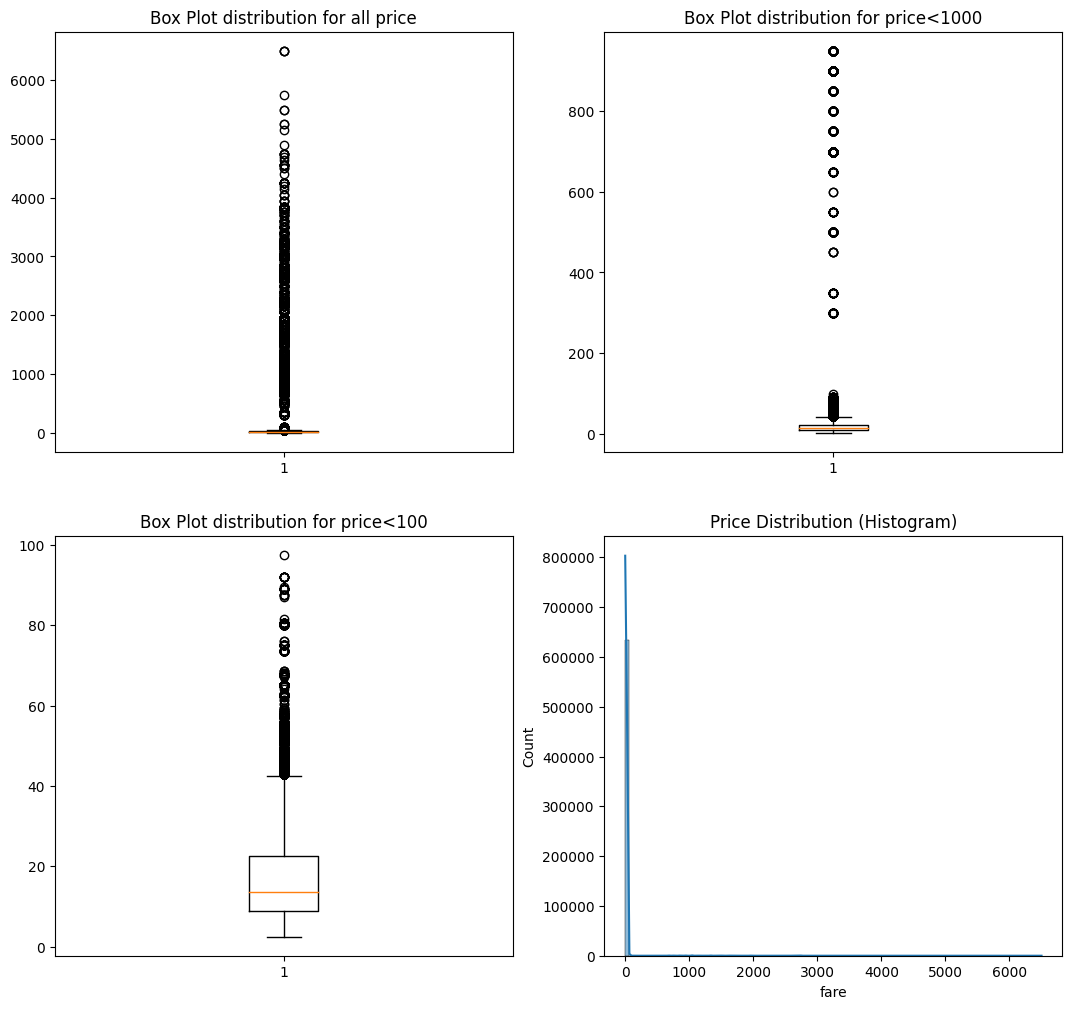

In [143]:
plt.figure(figsize=(13,12))
plt.subplot(2,2,1)
plt.boxplot(df["fare"])
plt.title("Box Plot distribution for all price")

plt.subplot(2,2,2)
plt.boxplot(df[df["fare"]<1000]["fare"])
plt.title("Box Plot distribution for price<1000")

plt.subplot(2,2,3)
plt.boxplot(df[df["fare"]<100]["fare"])
plt.title("Box Plot distribution for price<100")

plt.subplot(2,2,4)
sns.histplot(df["fare"], bins=100, kde=True)
plt.title("Price Distribution (Histogram)")
plt.show()

In [144]:
Q3 = df["fare"].quantile(0.75)
Q1 = df["fare"].quantile(0.25)

IQR = Q3-Q1
print(Q3 + 2 * IQR)

49.5


#### From above box plots and histogram distributions of price, we see that, the distribution is right skewed and price is highly concentrated below 100 and very less densely distributed above 100. 
#### And, Q3+2*IQR gives us 49.5 as outlier threshold.

In [145]:
df[(df["fare"]>50) & (df["fare"]<100)]

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,timestamp,date,hour,day_of_week,month,source,destination,ride_company,ride_type_id,ride_type,...,distance,surge_multiplier,fare,temperature,humidity,wind_speed,weather_desc_short,weather_desc_long,weather_status,pressure
6,2018-11-26 03:40:46,2018-11-26,3,Monday,11,Boston University,Financial District,Lyft,lyft_lux,Lux Black,...,4.46,1.75,62.5,41.83,0.92,0.51,Foggy,Rain in the morning and afternoon.,fog,1014.10
246,2018-11-26 04:43:18,2018-11-26,4,Monday,11,Financial District,Fenway,Lyft,lyft_luxsuv,Lux Black XL,...,4.55,1.50,62.5,41.52,0.90,0.45,Overcast,Rain in the morning and afternoon.,cloudy,1014.06
659,2018-11-26 05:14:02,2018-11-26,5,Monday,11,Financial District,Northeastern University,Lyft,lyft_luxsuv,Lux Black XL,...,3.42,1.50,52.5,41.99,0.91,0.53,Overcast,"Rain until morning, starting again in the eve...",cloudy,1014.11
1030,2018-11-26 05:50:01,2018-11-26,5,Monday,11,Northeastern University,Financial District,Lyft,lyft_lux,Lux Black,...,3.17,1.75,52.5,41.99,0.91,0.53,Overcast,"Rain until morning, starting again in the eve...",cloudy,1014.11
1041,2018-11-26 05:50:01,2018-11-26,5,Monday,11,Northeastern University,Financial District,Lyft,lyft_luxsuv,Lux Black XL,...,3.17,1.75,73.5,41.99,0.91,0.53,Overcast,"Rain until morning, starting again in the eve...",cloudy,1014.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635385,2018-12-18 18:15:10,2018-12-18,18,Tuesday,12,South Station,Back Bay,Lyft,lyft_luxsuv,Lux Black XL,...,3.23,2.00,75.0,20.78,0.41,13.14,Clear,Mostly cloudy throughout the day.,clear-day,1010.58
636051,2018-12-18 18:40:04,2018-12-18,18,Tuesday,12,Boston University,North Station,Lyft,lyft_luxsuv,Lux Black XL,...,3.44,1.50,55.0,20.78,0.41,13.14,Clear,Mostly cloudy throughout the day.,clear-day,1010.58
636253,2018-12-18 18:45:10,2018-12-18,18,Tuesday,12,North Station,Northeastern University,Lyft,lyft_luxsuv,Lux Black XL,...,NaN,1.25,52.5,20.78,0.41,13.14,Clear,Mostly cloudy throughout the day.,clear-day,1010.58
636306,2018-12-18 18:45:14,2018-12-18,18,Tuesday,12,Back Bay,North End,Lyft,lyft_lux,Lux Black,...,2.59,2.00,52.5,20.78,0.41,13.14,Clear,Mostly cloudy throughout the day.,clear-day,1010.58


In [146]:
df[(df["fare"]>50) & (df["fare"]<100)]["ride_type"].unique()

array(['Lux Black', 'Lux Black XL', 'Lux', 'UberXL', 'Black SUV', 'Black',
       'Lyft XL'], dtype=object)

In [147]:
df[df["fare"]<50]["ride_type"].unique()

array(['Black', 'Lux', 'Black SUV', 'WAV', 'UberX', 'Lyft', 'Shared',
       'Lux Black XL', 'UberXL', 'UberPool', 'Lux Black', 'Lyft XL'],
      dtype=object)

#### Here, we see that, price from 50 to 100 is only for rides in big and luxurious car. So, these are not outliers. They have higher price for better services.

In [148]:
len(df[df["fare"]>100])/len(df["fare"])*100

0.5056465433362001

In [149]:
df[df["fare"]>100].head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,timestamp,date,hour,day_of_week,month,source,destination,ride_company,ride_type_id,ride_type,...,distance,surge_multiplier,fare,temperature,humidity,wind_speed,weather_desc_short,weather_desc_long,weather_status,pressure
241,2018-11-26 04:43:18,2018-11-26,4,Monday,11,Financial District,Fenway,Lyft,lyft_lux,Lux Black,...,4.55,1.50,4750.0,41.52,NaN,0.45,Overcast,Rain in the morning and afternoon.,cloudy,1014.06
339,2018-11-26 04:49:39,2018-11-26,4,Monday,11,Northeastern University,West End,Lyft,lyft_lux,Lux Black,...,2.83,1.75,4550.0,41.52,0.90,0.45,Overcast,Rain in the morning and afternoon.,cloudy,1014.06
421,2018-11-26 04:55:44,2018-11-26,4,Monday,11,Boston University,Beacon Hill,Uber,6c84fd89-3f11-4782-9b50-97c468b19529,Black,...,2.79,1.00,2100.0,41.52,0.90,0.45,Overcast,Rain in the morning and afternoon.,cloudy,1014.06
511,2018-11-26 05:03:01,2018-11-26,5,Monday,11,Back Bay,Boston University,Lyft,lyft_line,Shared,...,1.45,1.00,500.0,41.99,0.91,0.53,Overcast,"Rain until morning, starting again in the eve...",cloudy,1014.11
571,2018-11-26 05:13:06,2018-11-26,5,Monday,11,Boston University,Financial District,Uber,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL,...,4.72,1.00,2150.0,41.99,0.91,0.53,Overcast,"Rain until morning, starting again in the eve...",cloudy,1014.11


In [150]:
df[df["fare"]>100]["ride_type"].unique()

array(['Lux Black', 'Black', 'Shared', 'UberXL', 'WAV', 'Lyft XL', 'Lux',
       'Black SUV', 'UberPool', 'Lyft', 'Lux Black XL', 'UberX'],
      dtype=object)

#### Price above 100 represents only 0.5% of the data. These are not big luxurious cars only. Also, their distance is not high either. All the rides of this dataset is inside Boston city. So, such high prices is not justified and it needs to be replaced with better representatives.

In [151]:
df["source"].unique()

array(['Beacon Hill', 'South Station', 'North Station',
       'Boston University', 'Northeastern University', 'Theatre District',
       'Haymarket Square', 'North End', 'Financial District', 'Fenway',
       'Back Bay', 'West End'], dtype=object)

In [152]:
df["destination"].unique()

array(['North End', 'Boston University', 'Beacon Hill', 'Fenway',
       'Financial District', 'Northeastern University',
       'Haymarket Square', 'Theatre District', 'North Station',
       'West End', 'South Station', 'Back Bay'], dtype=object)

In [153]:
df[["source","destination","ride_type"]].drop_duplicates()

,source,destination,ride_type
0,Beacon Hill,North End,Black
1,Beacon Hill,Boston University,Lux
2,South Station,Beacon Hill,Black SUV
3,North Station,Fenway,WAV
4,Beacon Hill,North End,UberX
...,...,...,...
4344,Fenway,Theatre District,Lux Black
5354,Boston University,Theatre District,UberXL
5545,Beacon Hill,Northeastern University,Lux Black XL
5668,Beacon Hill,Northeastern University,Shared


#### Pickup and dropoff locations are all in Boston and they are just 12 unique location. And, ride type also influences the price. So, we took unique combinations of these 3 feature. We will calculate the avg price of these unique combinations and impute that to the outliers.

In [154]:
price_threshold = 100

group_means = df[df["fare"] <= price_threshold].groupby(
    ["source", "destination", "ride_type"]
)["fare"].mean()

df.loc[df["fare"]>price_threshold, "fare"] = df[df["fare"]>price_threshold].apply(
    lambda row: group_means.get((row["source"], row["destination"], row["ride_type"]), np.nan),
    axis=1
)

In [155]:
print("Null Values in price column: ", df["fare"].isnull().sum())
df["fare"].describe()

Null Values in price column:  0


count    637204.000000
mean         16.547326
std           9.323871
min           2.500000
25%           9.000000
50%          13.500000
75%          22.500000
max          97.500000
Name: fare, dtype: float64

Max is 97.5. So, outliers removed.

### **Handling Outliers and Missing Values in Distance Column**

#### The `distance` column contains approximately 1% missing values. We will impute the missing values using geographical distance between pickup and drop-off locations based on the Haversine formula.



In [156]:
print("Null Values: ",df["distance"].isnull().sum())
df["distance"].describe()

Null Values:  6387


count    630817.000000
mean          3.294580
std          17.637139
min           0.020000
25%           1.280000
50%           2.170000
75%           2.950000
max         746.000000
Name: distance, dtype: float64

In [176]:
dist_threshold = df["distance"].quantile(0.99)
print(dist_threshold)
df[df["distance"]>dist_threshold][["fare","distance"]].head(7)

5.31


,fare,distance
41,34.0,6.26
423,13.5,5.56
433,12.5,5.56
453,13.5,5.56
505,14.0,5.56
700,27.0,5.70
701,48.0,5.70


In [159]:
df[df["distance"]>6.26]["fare"].sum() / df[df["distance"]>6.26]["distance"].sum()

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


0.15605958283383306

In [160]:
df[df["distance"]<6.26]["fare"].sum() / df[df["distance"]<6.26]["distance"].sum()

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)


7.619788453510651

A temp_df is created to store non null value of distance and visualize the data distribution.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


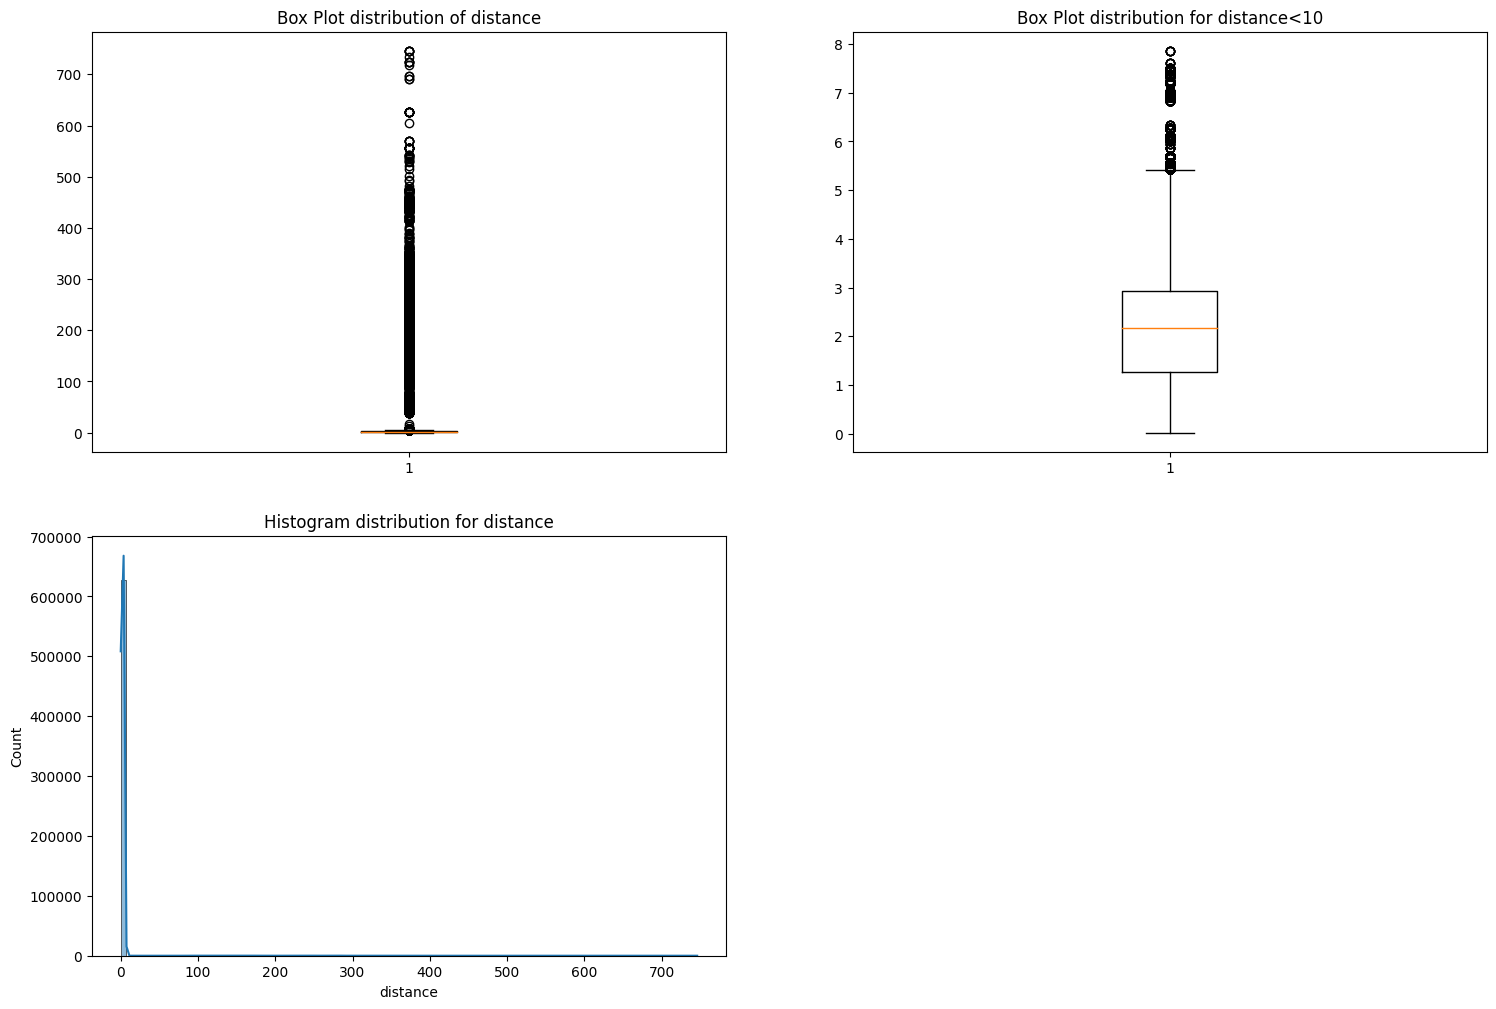

In [161]:
temp_df = df[~df["distance"].isna()]["distance"]

plt.figure(figsize=(18,12))
plt.subplot(2,2,1)
plt.boxplot(temp_df)
plt.title("Box Plot distribution of distance")

plt.subplot(2,2,2)
plt.boxplot(temp_df[temp_df<10])
plt.title("Box Plot distribution for distance<10")

plt.subplot(2,2,3)
sns.histplot(temp_df, bins=100, kde=True)
plt.title("Histogram distribution for distance")
plt.show()

del temp_df

75th and 99th percentile data is 2.94 and 6.26 respectively. 746 being the max number clearly shows presence of outliers as all the rides was inside Boston city.
when distance is > 6.26(99th percentile value), price to distance ratio is 0.16, while ratio of 7.62 is seen in the opposite case. As, price didn't increase proportionally with distance, it tells us that those distances are outliers. And, the box plots also say the same.
We will replace both the outliers and missing value in same method. As, there are only 12 unique locations and 72 unique combinations of pickup location and dropoff location. We will calculate the avg distance of those unique combinations and impute the value to missing value and outliers.

In [162]:
df.loc[df["distance"]>6.82, "distance"] = np.nan

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


We replaced the outliers with NaN and now all the missing values will be replaced by avg distance of the pickup and dropoff location.

In [163]:
# Group mean distances by source and destination
group_means = df.groupby(["source", "destination"])["distance"].mean()

# Replace NaN distances with the group mean or overall mean if group not found
df["distance"] = df.apply( lambda row: group_means.get((row["source"], row["distance"]), df['distance'].mean()) if pd.isna(row["distance"]) else row["distance"], axis=1)

df["distance"].isnull().sum()

0

In [164]:
print(df[["fare","distance"]].describe())
df[["fare","distance"]].isnull().sum()

                fare       distance
count  637204.000000  637204.000000
mean       16.547326       2.172116
std         9.323871       1.086976
min         2.500000       0.020000
25%         9.000000       1.300000
50%        13.500000       2.172116
75%        22.500000       2.880000
max        97.500000       6.330000


fare        0
distance    0
dtype: int64

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


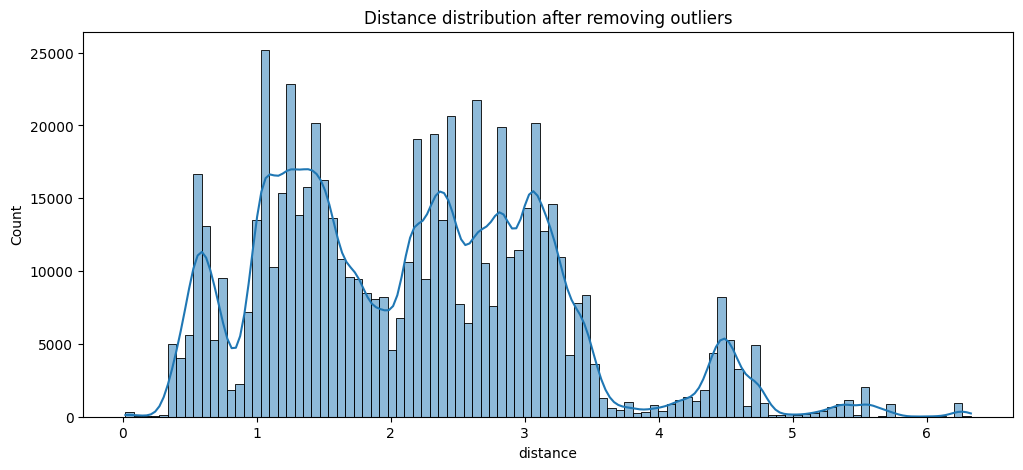

In [165]:
plt.figure(figsize=(12,5))
sns.histplot(df["distance"], bins=100, kde=True)
plt.title("Distance distribution after removing outliers")
plt.show()

Outliers and missing value for "price" and "distance" column has been handled.

## **Handling Outliers and Missing Values in Weather-Related Columns**

After cleaning and organizing the dataset, we now focus on key weather-related features: `temperature`, `humidity`, and `pressure`. These features can contain outliers or missing values that may affect model performance.

### **Strategy:**
1. **Detect and mark outliers** using the Interquartile Range (IQR) method.
2. **Replace outliers with `np.nan`** to treat them as missing data.
3. **Fill all missing values (including outliers) using forward and backward fill averaging**:
   - For each missing cell, take the average of the previous and next available values in the same column.


In [166]:
df[["temperature","humidity","pressure"]].describe()

,temperature,humidity,pressure
count,629798.000000,628554.000000,614455.000000
mean,36.721265,0.741022,1010.102495
std,11.330292,0.138582,13.474861
min,12.130000,0.380000,988.090000
25%,31.920000,0.640000,999.840000
50%,35.980000,0.710000,1009.250000
75%,40.720000,0.880000,1021.860000
max,171.660000,0.960000,1035.550000


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


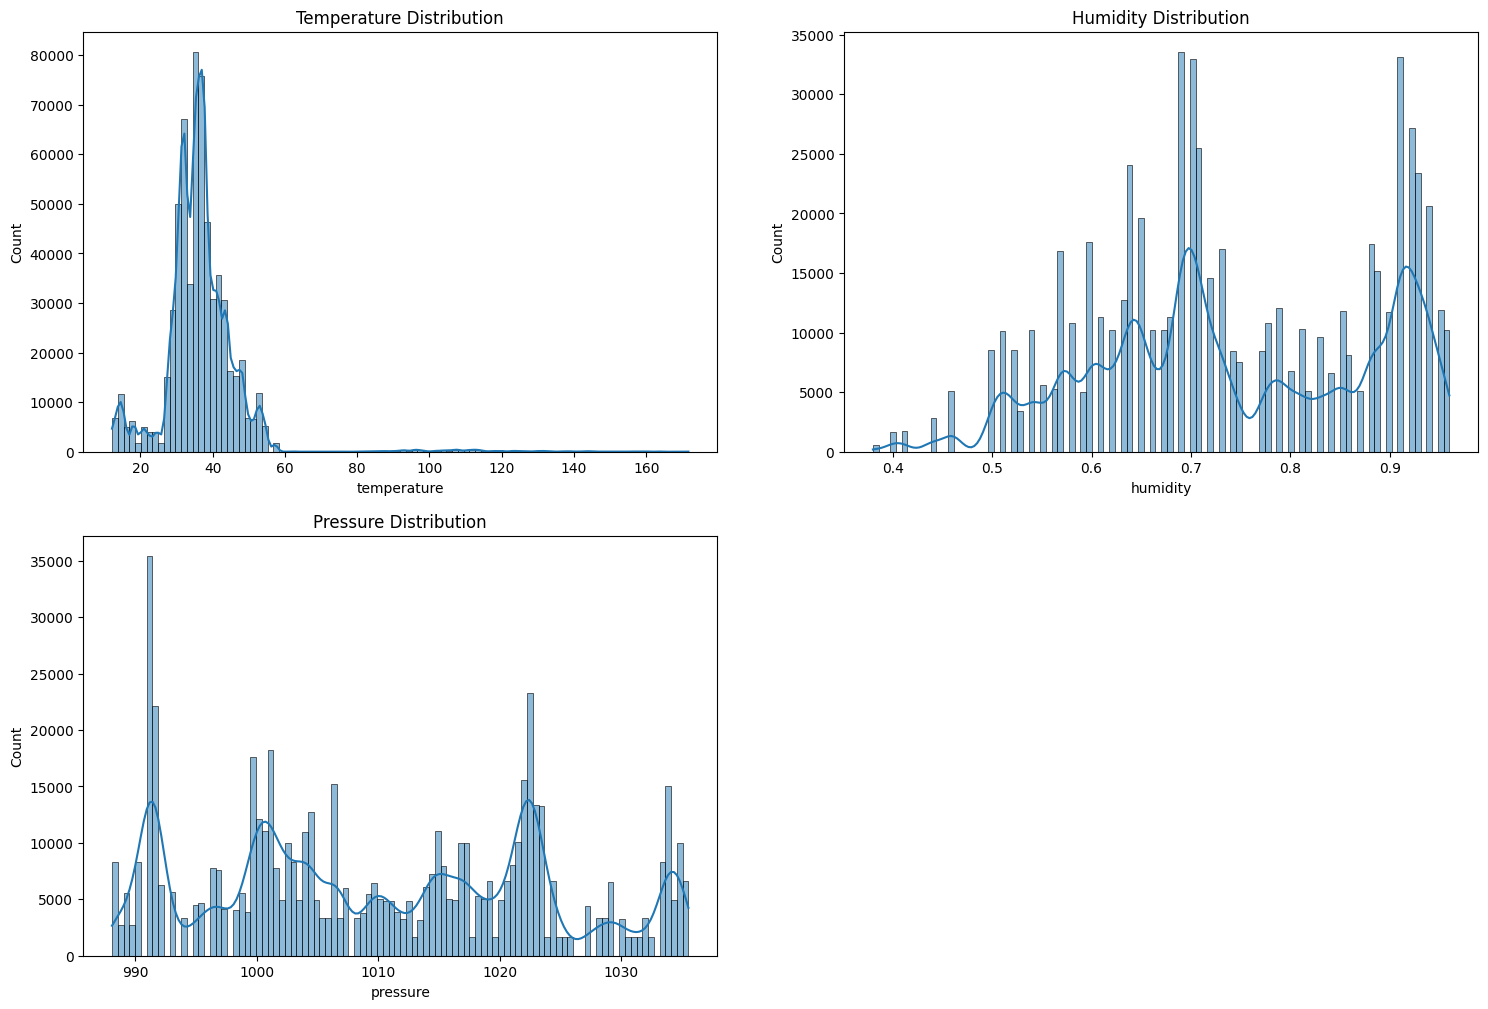

In [167]:
plt.figure(figsize=(18,12))
plt.subplot(2,2,1)
sns.histplot(df["temperature"], bins=100, kde=True)
plt.title("Temperature Distribution")

plt.subplot(2,2,2)
sns.histplot(df["humidity"], bins=100, kde=True)
plt.title("Humidity Distribution")

plt.subplot(2,2,3)
sns.histplot(df["pressure"], bins=100, kde=True)
plt.title("Pressure Distribution")
plt.show()

#### Only temperature column has unrealistic values.

In [168]:
Q3 = df["temperature"].quantile(0.75)
Q1 = df["temperature"].quantile(0.25)
IQR = Q3 - Q1
temp_threshold = Q3 + 1.5*IQR
print("Temperature Threshold: ",temp_threshold)
df.loc[df["temperature"]>temp_threshold, "temperature"] = np.nan

Temperature Threshold:  53.919999999999995


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


In [169]:
df["temperature"].isnull().sum()

21253

In [170]:
weather_cols = ["temperature", "humidity", "pressure"]

for col in weather_cols:
    df[col] = ((df[col].ffill() + df[col].bfill()) / 2).round(2)

In [171]:
df.isnull().sum()

timestamp                0
date                     0
hour                     0
day_of_week              0
month                    0
source                   0
destination              0
ride_company             0
ride_type_id             0
ride_type                0
visibility               0
cloud_cover              0
uv_index                 0
distance                 0
surge_multiplier      3590
fare                     0
temperature              0
humidity                 0
wind_speed               0
weather_desc_short       0
weather_desc_long        0
weather_status           0
pressure                 0
dtype: int64

In [172]:
df["surge_multiplier"].describe()

count    633614.000000
mean          1.015088
std           0.095493
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           3.000000
Name: surge_multiplier, dtype: float64

In [178]:
print(len(df[df["surge_multiplier"]>1])/len(df)*100)
print(df["fare"].mean())
print(df[df["surge_multiplier"]>1]["fare"].mean())
print(df[df["surge_multiplier"]>1]["ride_type"].unique())
df[df["surge_multiplier"]>1].head()

3.2739907470762892
16.547326130735026
27.791817793592347
['Lux' 'Lux Black' 'Lyft XL' 'Lux Black XL' 'Lyft']


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


,timestamp,date,hour,day_of_week,month,source,destination,ride_company,ride_type_id,ride_type,...,distance,surge_multiplier,fare,temperature,humidity,wind_speed,weather_desc_short,weather_desc_long,weather_status,pressure
5,2018-11-26 03:40:46,2018-11-26,3,Monday,11,Boston University,Financial District,Lyft,lyft_premier,Lux,...,4.46,1.75,47.5,41.83,0.92,0.51,Foggy,Rain in the morning and afternoon.,fog,1014.10
6,2018-11-26 03:40:46,2018-11-26,3,Monday,11,Boston University,Financial District,Lyft,lyft_lux,Lux Black,...,4.46,1.75,62.5,41.83,0.92,0.51,Foggy,Rain in the morning and afternoon.,fog,1014.10
49,2018-11-26 03:40:47,2018-11-26,3,Monday,11,Fenway,Beacon Hill,Lyft,lyft_plus,Lyft XL,...,2.40,1.25,19.5,41.83,0.92,0.51,Foggy,Rain in the morning and afternoon.,fog,1014.10
78,2018-11-26 04:40:55,2018-11-26,4,Monday,11,Boston University,Beacon Hill,Lyft,lyft_luxsuv,Lux Black XL,...,2.70,1.25,38.0,41.52,0.90,0.45,Overcast,Rain in the morning and afternoon.,cloudy,1014.06
79,2018-11-26 04:40:55,2018-11-26,4,Monday,11,Boston University,Beacon Hill,Lyft,lyft_premier,Lux,...,2.70,1.25,22.5,41.52,0.90,0.45,Overcast,Rain in the morning and afternoon.,cloudy,1014.06


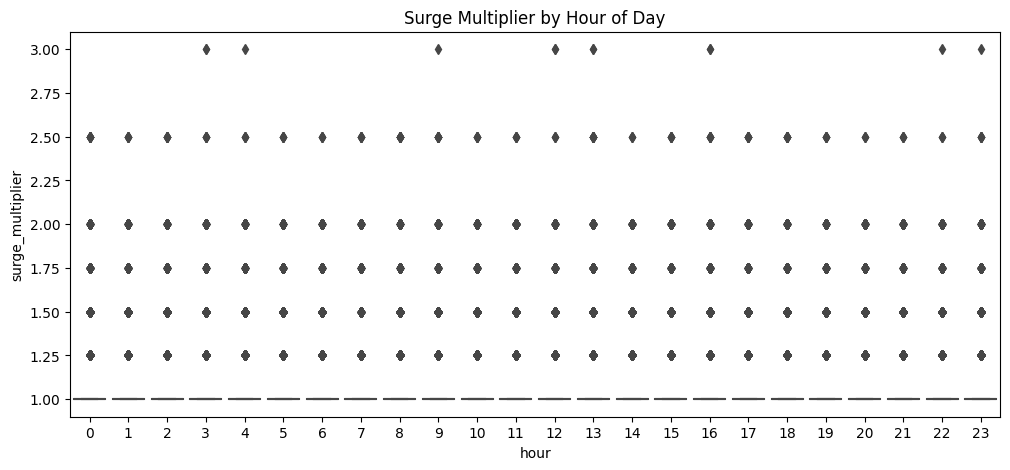

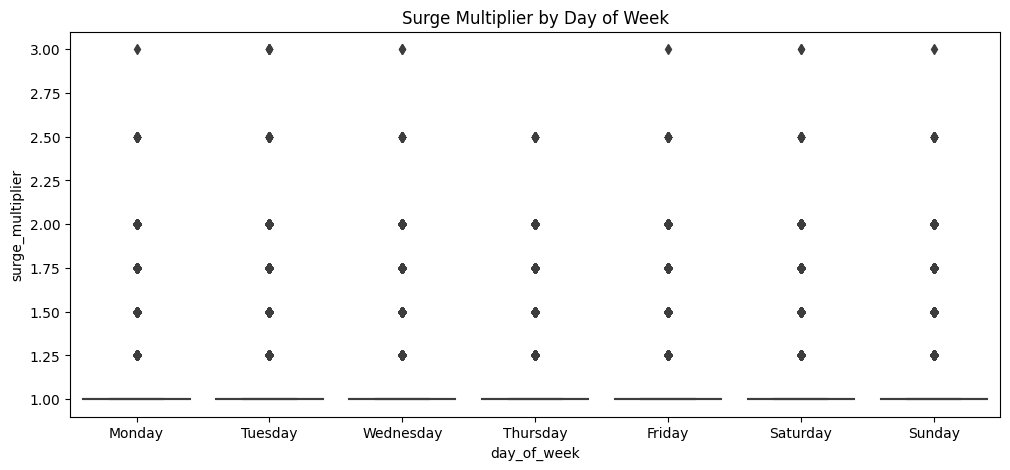

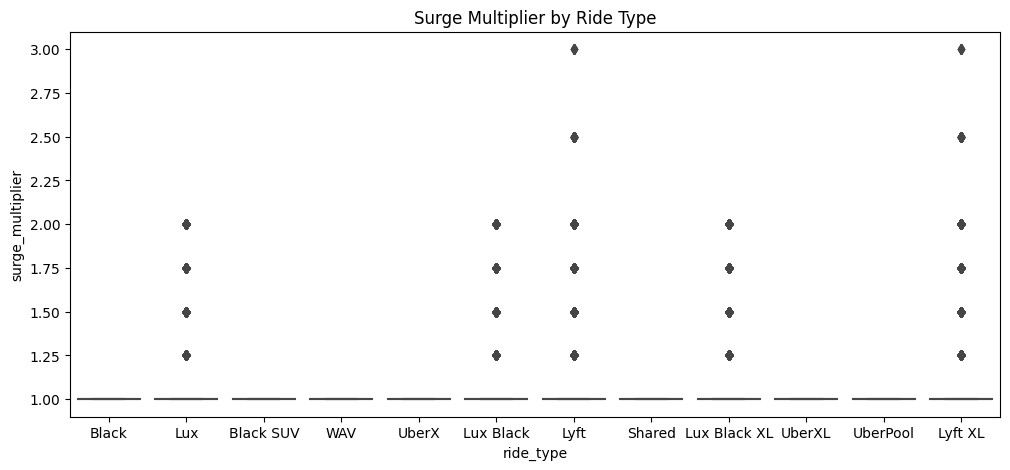

In [174]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
sns.boxplot(x="hour", y="surge_multiplier", data=df)
plt.title("Surge Multiplier by Hour of Day")
plt.show()

plt.figure(figsize=(12, 5))
sns.boxplot(x="day_of_week", y="surge_multiplier", data=df)
plt.title("Surge Multiplier by Day of Week")
plt.show()

plt.figure(figsize=(12, 5))
sns.boxplot(x="ride_type", y="surge_multiplier", data=df)
plt.title("Surge Multiplier by Ride Type")
plt.show()